## Задание 6

Обучить сиамскую сеть для верификации лиц на датасете LFW       
Библиотеки: [Python, Tensorflow]  

### Подключение библиотек и скриптов

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# For Google Colaboratory
%tensorflow_version 2.x

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers

from sklearn.manifold import TSNE

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
plt.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 300)

### Tensorflow with GPU

In [5]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### Загрузка данных

In [6]:
tfds.disable_progress_bar()

(train_ds, test_ds), ds_info = tfds.load('lfw', 
                                         as_supervised=True, 
                                         with_info=True, 
                                         split=['train[:90%]', 
                                                'train[90%:]'],
                                         )

### Изучение датасета

In [7]:
ds_info

tfds.core.DatasetInfo(
    name='lfw',
    version=0.1.0,
    description='Labeled Faces in the Wild:
        A Database for Studying Face Recognition in
        Unconstrained Environments',
    homepage='http://vis-www.cs.umass.edu/lfw',
    features=FeaturesDict({
        'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
        'label': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=13233,
    splits={
        'train': 13233,
    },
    supervised_keys=('label', 'image'),
    citation="""@TechReport{LFWTech,
        author = {Gary B. Huang and Manu Ramesh and Tamara Berg and Erik Learned-Miller},
        title = {Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments},
        institution = {University of Massachusetts, Amherst},
        year = 2007,
        number = {07-49},
        month = {October}
    }""",
    redistribution_info=,
)

In [8]:
len(train_ds), len(test_ds)

(11910, 1323)

### Визуализация датасета - Labeled Faces in the Wild

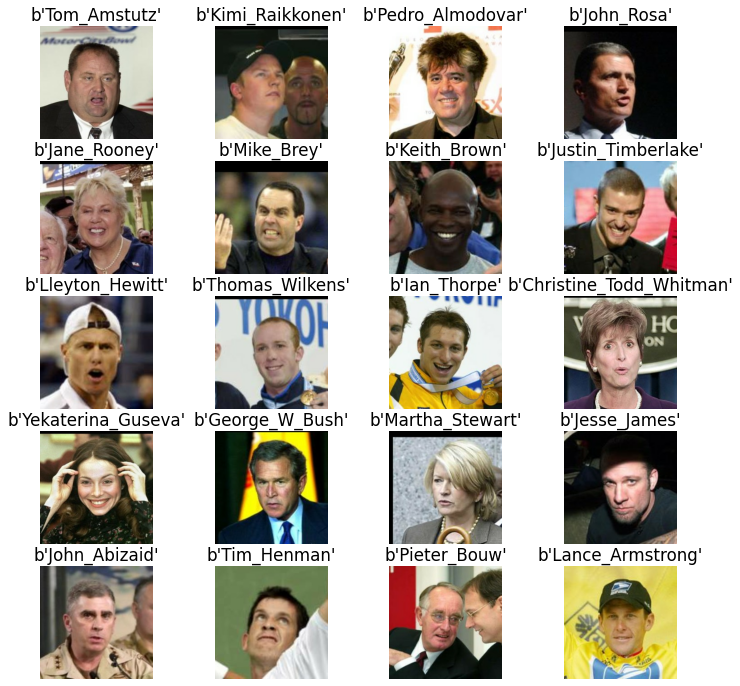

In [9]:
plt.figure(figsize=(12, 12))
for i, x in enumerate(train_ds.take(20)):
    plt.subplot(5, 4, i+1)
    plt.title(x[0].numpy())
    plt.imshow(x[1])
    plt.axis('off')

### Создание пайплайна данных

In [10]:
INP_SIZE = 128
EPOCHS = 55
BATCH_SIZE = 64

def prepare_images(label, img):
    img = tf.cast(img, tf.float32) / 255.
    img = tf.reduce_mean(img, 2)
    img = tf.reshape(img, (250, 250, 1))
    img = tf.image.resize(img, (INP_SIZE, INP_SIZE))
    return label, img

train_ds = train_ds.map(prepare_images)
train_ds = train_ds.repeat(EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE)

test_ds = test_ds.map(prepare_images)
test_ds = test_ds.batch(BATCH_SIZE)

### Model

In [11]:
EMB_SIZE = 64

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(EMB_SIZE, activation=None)
])

### Contrastive Loss

In [12]:
MARGIN = 10.0

def contastive_loss(embs, labels):
    bs = embs.shape[0]
    
    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d = tf.sqrt(d2)
    z = tf.cast(labels1 == labels2, tf.float32)
    
    return tf.reduce_mean(z * d2 + (1 - z) * tf.maximum(0, MARGIN - d)**2)

In [13]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Nadam(LEARNING_RATE)
# optimizer = tf.keras.optimizers.RMSprop(LEARNING_RATE)

In [14]:
%%time

labels_v, images_v = next(iter(test_ds))

train_loss = []
test_loss = []

for i, (labels, images) in enumerate(train_ds):
    # Forward
    with tf.GradientTape() as tape:
        embs = model(images)
        loss = contastive_loss(embs, labels)
    
    # Backward    
    grads = tape.gradient(loss, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))
    
    if i % 500 == 0:
        test_embs = model(images_v)
        val_loss = contastive_loss(test_embs, labels_v)
        
        train_loss.append(loss)
        test_loss.append(val_loss)
        
        print(f'[{i}]\t loss: {loss.numpy():.4f}\t| val_loss: {val_loss.numpy():.4f}')

[0]	 loss: 97.0467	| val_loss: 13.8075
[500]	 loss: 0.6995	| val_loss: 0.3032
[1000]	 loss: 0.3752	| val_loss: 0.0000
[1500]	 loss: 0.0000	| val_loss: 0.0000
[2000]	 loss: 0.4522	| val_loss: 0.5045
[2500]	 loss: 0.3571	| val_loss: 0.0044
[3000]	 loss: 0.0036	| val_loss: 0.0000
[3500]	 loss: 0.0749	| val_loss: 0.0000
[4000]	 loss: 0.0000	| val_loss: 0.0000
[4500]	 loss: 0.0145	| val_loss: 0.0000
[5000]	 loss: 0.0000	| val_loss: 0.0000
[5500]	 loss: 0.0000	| val_loss: 0.0000
[6000]	 loss: 0.0000	| val_loss: 0.0006
[6500]	 loss: 3.7668	| val_loss: 0.9569
[7000]	 loss: 0.0000	| val_loss: 0.0000
[7500]	 loss: 0.0000	| val_loss: 0.0159
[8000]	 loss: 0.0000	| val_loss: 0.0000
[8500]	 loss: 0.1420	| val_loss: 0.0000
[9000]	 loss: 0.2745	| val_loss: 0.0000
[9500]	 loss: 0.0203	| val_loss: 0.0000
[10000]	 loss: 0.0000	| val_loss: 0.0000
CPU times: user 16min 31s, sys: 52.3 s, total: 17min 24s
Wall time: 11min 45s


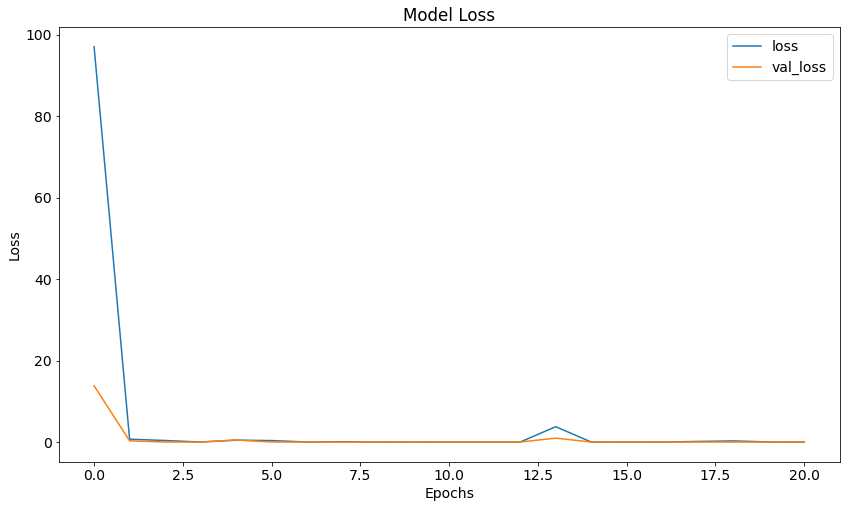

In [15]:
plt.figure(figsize=(14, 8))
plt.plot(train_loss, label='loss')
plt.plot(test_loss, label='val_loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.show()

### Визуализация эмбеддингов в 2D пространстве с помощью TSNE

In [16]:
test_embs = model(images_v)

In [17]:
test_embs_2D = TSNE(n_components=2).fit_transform(test_embs)
labels_for_viz = labels_v

In [18]:
labels_for_viz

<tf.Tensor: shape=(64,), dtype=string, numpy=
array([b'Francis_Collins', b'Jose_Luis_Santiago_Vasconcelos',
       b'Georgi_Parvanov', b'Donald_Rumsfeld', b'Kiki_Vandeweghe',
       b'Juan_Valencia_Osorio', b'Brian_StPierre', b'Jacques_Chirac',
       b'Silvio_Berlusconi', b'Andrew_Cuomo', b'Derek_Jeter',
       b'Colin_Powell', b'Gene_Orza', b'Adrien_Brody', b'Thomas_OBrien',
       b'Tiger_Woods', b'Steven_Tyler', b'Rolf_Eckrodt',
       b'Nicanor_Duarte_Frutos', b'Colin_Powell', b'Taha_Yassin_Ramadan',
       b'Michael_Douglas', b'Jefferson_Perez', b'Li_Zhaoxing',
       b'Camilla_Parker_Bowles', b'Princess_Hisako', b'Denise_Locke',
       b'Pierre_Png', b'Prince_Rainier_III', b'Jim_Taylor',
       b'Yashwant_Sinha', b'Carrie-Anne_Moss', b'Jamie_Villafane',
       b'Hamid_Karzai', b'Hugo_Chavez', b'Vladimir_Putin',
       b'Gene_Robinson', b'Alvaro_Uribe', b'George_W_Bush',
       b'Anna_Kournikova', b'Andrew_Sabey', b'Ariel_Sharon', b'Ernie_Els',
       b'Tony_Blair', b'Sadie_Frost

In [19]:
# selected_words = ['George_W_Bush', 'Colin_Powell', 'Donald_Rumsfeld',
#                   'Tony_Blair', 'Gerhard_Schroeder', 'Jacques_Chirac',
#                   'Anna_Kournikova', 'Vladimir_Putin', 'Jackie_Chan']

# plt.figure(figsize=(19, 16))
# # plot all the embeddings and their corresponding words
# for i, label in enumerate(labels_for_viz):
#     x, y = test_embs_2D[i,:] 
#     plt.scatter(x, y)
#     if label in selected_words:
#         plt.annotate(label.numpy(), xy=(x, y), xytext=(5, 2), textcoords='offset points',
#                        ha='right', va='bottom', fontsize=10)
        
# plt.show()

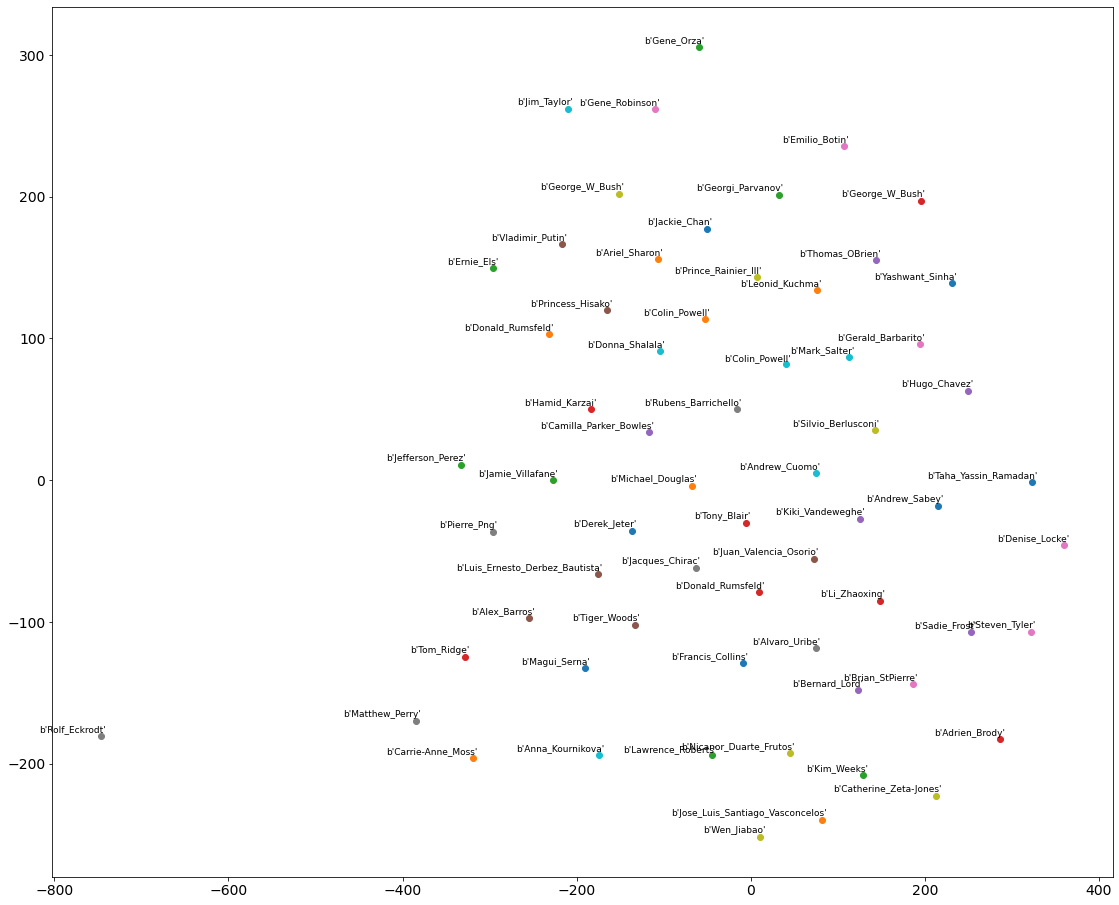

In [20]:
plt.figure(figsize=(19, 16))
# plot all the embeddings and their corresponding words
for i, label in enumerate(labels_for_viz):
    x, y = test_embs_2D[i,:] 
    plt.scatter(x, y)
    plt.annotate(label.numpy(), xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom', fontsize=9)  
plt.show()

### Тестовые данные

In [21]:
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

In [22]:
np.where(labels_for_viz == b'Vladimir_Putin')[0]

array([35])

In [23]:
np.where(labels_for_viz == b'Anna_Kournikova')[0]

array([39])

In [24]:
np.where(labels_for_viz == b'Jackie_Chan')[0]

array([50])

In [25]:
np.where(labels_for_viz == b'George_W_Bush')[0]

array([38, 53])

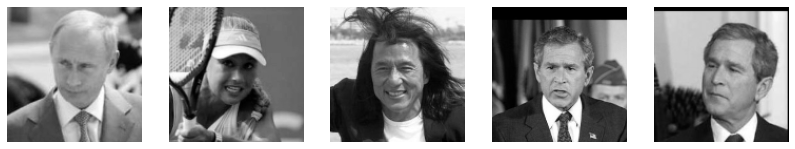

In [26]:
plt.figure(figsize=(14, 14))
plt.subplot(1, 5, 1)
plt.imshow(images_v[35, ..., 0], cmap='gray')
plt.axis('off')
plt.subplot(1, 5, 2)
plt.imshow(images_v[39, ..., 0], cmap='gray')
plt.axis('off')
plt.subplot(1, 5, 3)
plt.imshow(images_v[50, ..., 0], cmap='gray')
plt.axis('off')
plt.subplot(1, 5, 4)
plt.imshow(images_v[38, ..., 0], cmap='gray')
plt.axis('off')
plt.subplot(1, 5, 5)
plt.imshow(images_v[53, ..., 0], cmap='gray')
plt.axis('off')
plt.show()

In [27]:
putin_01 = test_embs_2D[35]
kurnikova_01 = test_embs_2D[39]
chan_01 = test_embs_2D[50]
bush_01 = test_embs_2D[38]
bush_02 = test_embs_2D[53]

print('Putin <-> Kurnikova: ', diff(putin_01, kurnikova_01))
print('Putin <-> Chan: ', diff(putin_01, chan_01))
print('Putin <-> Bush: ', diff(putin_01, bush_01))
print('Putin <-> Bush2: ', diff(putin_01, bush_02))
print('Kurnikova <-> Chan: ', diff(kurnikova_01, chan_01))
print('Kurnikova <-> Bush: ', diff(kurnikova_01, bush_01))
print('Kurnikova <-> Bush2: ', diff(kurnikova_01, bush_02))
print('Chan <-> Bush: ', diff(chan_01, bush_01))
print('Chan <-> Bush2: ', diff(chan_01, bush_02))
print('Bush <-> Bush2: ', diff(bush_01, bush_02))

Putin <-> Kurnikova:  362.7220656025768
Putin <-> Chan:  167.11802294710765
Putin <-> Bush:  74.78923510439186
Putin <-> Bush2:  413.05725617037643
Kurnikova <-> Chan:  391.3391871190515
Kurnikova <-> Bush:  396.59996375441085
Kurnikova <-> Bush2:  537.3759159098963
Chan <-> Bush:  104.05080640004671
Chan <-> Bush2:  245.94741879617277
Bush <-> Bush2:  346.2932621890007


### Тестирование на новых данных

In [28]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [29]:
path_to_file = '/content/gdrive/MyDrive/Colab Notebooks/my_projects/'

In [30]:
def load_and_prepare_image(path_to_file):
    import imageio
    from skimage.transform import resize
    img = imageio.imread(path_to_file, pilmode='RGB')
    img = img.astype(np.float32) / 255
    img = resize(img, (INP_SIZE, INP_SIZE), order=3, mode='reflect', anti_aliasing=True)
    img = (1. - img).astype(np.float32)
    img = np.mean(img, axis=2)
    img = np.reshape(img, (INP_SIZE, INP_SIZE, 1))
    return img

img_a1 = load_and_prepare_image(path_to_file + 'putin.jpg')
img_b1 = load_and_prepare_image(path_to_file + 'kurnikova.jpg')
img_c1 = load_and_prepare_image(path_to_file +'chan.jpg')
img_c2 = load_and_prepare_image(path_to_file +'chan2.jpg')
img_c3 = load_and_prepare_image(path_to_file +'chan3.jpg')

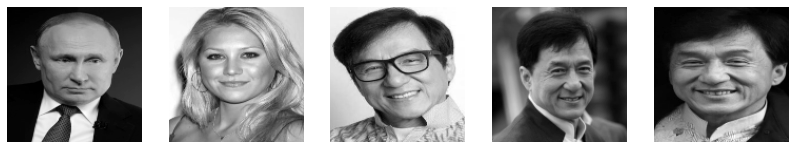

In [31]:
fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(1, 5, 1)
ax.imshow(img_a1[:,:,0], cmap='gray_r')
plt.axis('off')
ax = fig.add_subplot(1, 5, 2)
ax.imshow(img_b1[:,:,0], cmap='gray_r')
plt.axis('off')
ax = fig.add_subplot(1, 5, 3)
ax.imshow(img_c1[:,:,0], cmap='gray_r')
plt.axis('off')
ax = fig.add_subplot(1, 5, 4)
ax.imshow(img_c2[:,:,0], cmap='gray_r')
plt.axis('off')
ax = fig.add_subplot(1, 5, 5)
ax.imshow(img_c3[:,:,0], cmap='gray_r')
plt.axis('off')
plt.show()

In [32]:
new_embs = model(np.stack((img_a1, img_b1, img_c1, img_c2, img_c3), axis=0))

### Вычисление расстояний между эмбеддингами

In [33]:
putin_02 = new_embs[0,:]
kurnikova_02 = new_embs[1,:]
chan_02 = new_embs[2,:]
chan_03 = new_embs[3,:]
chan_04 = new_embs[4,:]

print('Putin <-> Kurnikova: ', diff(putin_02, kurnikova_02))
print('Putin <-> Chan: ', diff(putin_02, chan_02))
print('Putin <-> Chan2: ', diff(putin_02, chan_03))
print('Putin <-> Chan3: ', diff(putin_02, chan_04))
print('Kurnikova <-> Chan: ', diff(kurnikova_02, chan_02))
print('Kurnikova <-> Chan2: ', diff(kurnikova_02, chan_03))
print('Kurnikova <-> Chan3: ', diff(kurnikova_02, chan_04))
print('Chan <-> Chan2: ', diff(chan_02, chan_03))
print('Chan <-> Chan3: ', diff(chan_02, chan_04))
print('Chan2 <-> Chan3: ', diff(chan_03, chan_04))

Putin <-> Kurnikova:  13.598415372195602
Putin <-> Chan:  15.203948983644533
Putin <-> Chan2:  8.889607188554333
Putin <-> Chan3:  6.38389774280768
Kurnikova <-> Chan:  13.03779975349021
Kurnikova <-> Chan2:  9.12965044637248
Kurnikova <-> Chan3:  8.462618589485956
Chan <-> Chan2:  13.554104927142056
Chan <-> Chan3:  12.837312816232098
Chan2 <-> Chan3:  4.307835807086931


### Framework DeepFace

In [34]:
# !pip install deepface

In [35]:
from deepface import DeepFace

In [36]:
# ['VGG-Face', 'Facenet', 'OpenFace', 'DeepFace', 'DeepID', 'ArcFace', 'Dlib']

In [37]:
putin = path_to_file + 'putin.jpg'
kurnikova = path_to_file + 'kurnikova.jpg'
chan = path_to_file +'chan.jpg'
chan2 = path_to_file +'chan2.jpg'
chan3 = path_to_file +'chan3.jpg'

### ArcFace

In [41]:
print('Putin <-> Kurnikova: ', DeepFace.verify(putin, kurnikova, model_name = 'ArcFace'))
print('Putin <-> Chan: ', DeepFace.verify(putin, chan, model_name = 'ArcFace'))
print('Putin <-> Chan2: ', DeepFace.verify(putin, chan2, model_name = 'ArcFace'))
print('Putin <-> Chan3: ', DeepFace.verify(putin, chan3, model_name = 'ArcFace'))
print('Kurnikova <-> Chan: ', DeepFace.verify(kurnikova, chan, model_name = 'ArcFace'))
print('Kurnikova <-> Chan2: ', DeepFace.verify(kurnikova, chan2, model_name = 'ArcFace'))
print('Kurnikova <-> Chan3: ', DeepFace.verify(kurnikova, chan3, model_name = 'ArcFace'))
print('Chan <-> Chan2: ', DeepFace.verify(chan, chan2, model_name = 'ArcFace'))
print('Chan <-> Chan3: ', DeepFace.verify(chan, chan3, model_name = 'ArcFace'))
print('Chan2 <-> Chan3: ', DeepFace.verify(chan2, chan3, model_name = 'ArcFace'))

Putin <-> Kurnikova:  {'verified': True, 'distance': 0.0475195244258273, 'max_threshold_to_verify': 0.6871912959056619, 'model': 'ArcFace', 'similarity_metric': 'cosine'}
Putin <-> Chan:  {'verified': True, 'distance': 0.09615851873570025, 'max_threshold_to_verify': 0.6871912959056619, 'model': 'ArcFace', 'similarity_metric': 'cosine'}
Putin <-> Chan2:  {'verified': True, 'distance': 0.10773795081258963, 'max_threshold_to_verify': 0.6871912959056619, 'model': 'ArcFace', 'similarity_metric': 'cosine'}
Putin <-> Chan3:  {'verified': True, 'distance': 0.06605869094016881, 'max_threshold_to_verify': 0.6871912959056619, 'model': 'ArcFace', 'similarity_metric': 'cosine'}
Kurnikova <-> Chan:  {'verified': True, 'distance': 0.06415408742457318, 'max_threshold_to_verify': 0.6871912959056619, 'model': 'ArcFace', 'similarity_metric': 'cosine'}
Kurnikova <-> Chan2:  {'verified': True, 'distance': 0.08037215345268856, 'max_threshold_to_verify': 0.6871912959056619, 'model': 'ArcFace', 'similarity_me

### DeepFace

In [39]:
print('Putin <-> Kurnikova: ', DeepFace.verify(putin, kurnikova, model_name = 'DeepFace'))
print('Putin <-> Chan: ', DeepFace.verify(putin, chan, model_name = 'DeepFace'))
print('Putin <-> Chan2: ', DeepFace.verify(putin, chan2, model_name = 'DeepFace'))
print('Putin <-> Chan3: ', DeepFace.verify(putin, chan3, model_name = 'DeepFace'))
print('Kurnikova <-> Chan: ', DeepFace.verify(kurnikova, chan, model_name = 'DeepFace'))
print('Kurnikova <-> Chan2: ', DeepFace.verify(kurnikova, chan2, model_name = 'DeepFace'))
print('Kurnikova <-> Chan3: ', DeepFace.verify(kurnikova, chan3, model_name = 'DeepFace'))
print('Chan <-> Chan2: ', DeepFace.verify(chan, chan2, model_name = 'DeepFace'))
print('Chan <-> Chan3: ', DeepFace.verify(chan, chan3, model_name = 'DeepFace'))
print('Chan2 <-> Chan3: ', DeepFace.verify(chan2, chan3, model_name = 'DeepFace'))

Putin <-> Kurnikova:  {'verified': False, 'distance': 0.39930275098312507, 'max_threshold_to_verify': 0.23, 'model': 'DeepFace', 'similarity_metric': 'cosine'}
Putin <-> Chan:  {'verified': False, 'distance': 0.32392695998422805, 'max_threshold_to_verify': 0.23, 'model': 'DeepFace', 'similarity_metric': 'cosine'}
Putin <-> Chan2:  {'verified': False, 'distance': 0.40023033691143495, 'max_threshold_to_verify': 0.23, 'model': 'DeepFace', 'similarity_metric': 'cosine'}
Putin <-> Chan3:  {'verified': False, 'distance': 0.4167602352974872, 'max_threshold_to_verify': 0.23, 'model': 'DeepFace', 'similarity_metric': 'cosine'}
Kurnikova <-> Chan:  {'verified': False, 'distance': 0.33969724010542723, 'max_threshold_to_verify': 0.23, 'model': 'DeepFace', 'similarity_metric': 'cosine'}
Kurnikova <-> Chan2:  {'verified': False, 'distance': 0.3283589810040274, 'max_threshold_to_verify': 0.23, 'model': 'DeepFace', 'similarity_metric': 'cosine'}
Kurnikova <-> Chan3:  {'verified': False, 'distance': 0.

### Dlib

In [40]:
print('Putin <-> Kurnikova: ', DeepFace.verify(putin, kurnikova, model_name = 'Dlib'))
print('Putin <-> Chan: ', DeepFace.verify(putin, chan, model_name = 'Dlib'))
print('Putin <-> Chan2: ', DeepFace.verify(putin, chan2, model_name = 'Dlib'))
print('Putin <-> Chan3: ', DeepFace.verify(putin, chan3, model_name = 'Dlib'))
print('Kurnikova <-> Chan: ', DeepFace.verify(kurnikova, chan, model_name = 'Dlib'))
print('Kurnikova <-> Chan2: ', DeepFace.verify(kurnikova, chan2, model_name = 'Dlib'))
print('Kurnikova <-> Chan3: ', DeepFace.verify(kurnikova, chan3, model_name = 'Dlib'))
print('Chan <-> Chan2: ', DeepFace.verify(chan, chan2, model_name = 'Dlib'))
print('Chan <-> Chan3: ', DeepFace.verify(chan, chan3, model_name = 'Dlib'))
print('Chan2 <-> Chan3: ', DeepFace.verify(chan2, chan3, model_name = 'Dlib'))

Putin <-> Kurnikova:  {'verified': False, 'distance': 0.16155039746601174, 'max_threshold_to_verify': 0.07, 'model': 'Dlib', 'similarity_metric': 'cosine'}
Putin <-> Chan:  {'verified': False, 'distance': 0.13319823258177577, 'max_threshold_to_verify': 0.07, 'model': 'Dlib', 'similarity_metric': 'cosine'}
Putin <-> Chan2:  {'verified': False, 'distance': 0.1570021903729132, 'max_threshold_to_verify': 0.07, 'model': 'Dlib', 'similarity_metric': 'cosine'}
Putin <-> Chan3:  {'verified': False, 'distance': 0.12339725871717233, 'max_threshold_to_verify': 0.07, 'model': 'Dlib', 'similarity_metric': 'cosine'}
Kurnikova <-> Chan:  {'verified': False, 'distance': 0.18929538591206396, 'max_threshold_to_verify': 0.07, 'model': 'Dlib', 'similarity_metric': 'cosine'}
Kurnikova <-> Chan2:  {'verified': False, 'distance': 0.2031279483439168, 'max_threshold_to_verify': 0.07, 'model': 'Dlib', 'similarity_metric': 'cosine'}
Kurnikova <-> Chan3:  {'verified': False, 'distance': 0.20052084280470595, 'max_